# Lab 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

1. Зниження розмірності і візуалізація даних

Застосуйте методи зниження розмірності sklearn.decomposition.PCA і sklearn.manifold.TSNE для візуалізації даних, з якими ви працювали в лабораторній № 1 (знижуючи розмірність до двох). Візуалізуйте результат.

2. Кластерний аналіз

1) За допомогою алгоритму k-means зробіть квантування зображення (видалення візуально надлишкової інформації) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення.

3. Обробка та класифікація текстових даних

Завантажте набір текстових даних (з мітками класів). Проведіть передобробку даних (видаліть стоп-слова, пунктуацію), за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer). Проведіть класифікацію текстових даних, зробіть оцінку якості. 

In [1]:
#1 

import pandas as pd

data = pd.read_csv("jobclassinfo2.csv")

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for feat_name in ['JobFamilyDescription','JobClassDescription','PG']: 
    data[feat_name] = le.fit_transform(data[feat_name])

from sklearn.preprocessing import StandardScaler

features = data.drop(['ID','PG'],axis=1).columns
X = data[features].values
y = data['PG'].values

scaler = preprocessing.MinMaxScaler()
X_std = scaler.fit_transform(X)

In [2]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

print('exp_var_pca: ', exp_var_pca, '\ncum_sum_eigenvalues: ', cum_sum_eigenvalues)

exp_var_pca:  [0.57033231 0.28552307] 
cum_sum_eigenvalues:  [0.57033231 0.85585538]


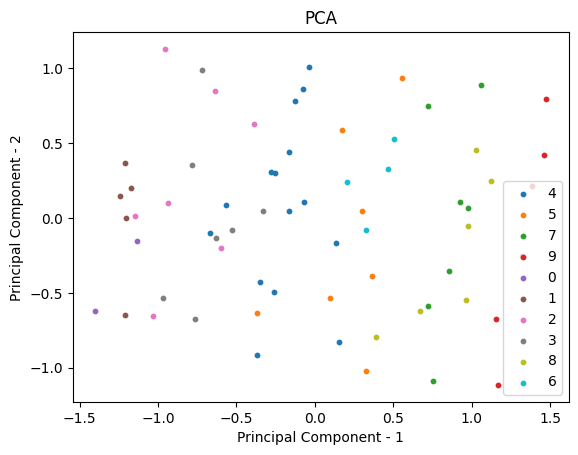

In [3]:
import matplotlib.pyplot as plt

for i in data['PG'].unique(): 
    plt.scatter(X_pca[data['PG'] == i, 0], 
                X_pca[data['PG'] == i, 1],  
                s=10, label = i) 
plt.title("PCA")
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.legend() 
plt.show()

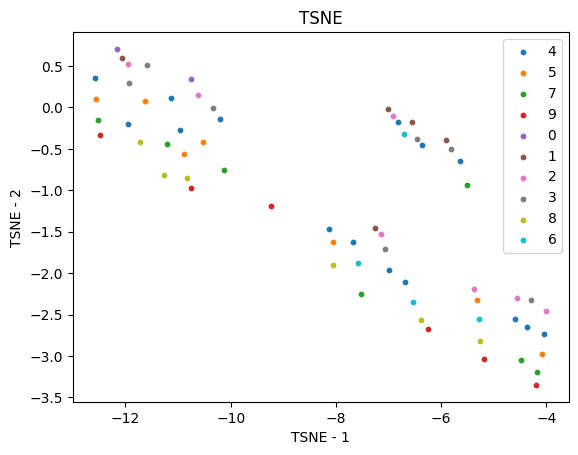

In [4]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

for i in data['PG'].unique(): 
    plt.scatter(X_tsne[data['PG'] == i, 0], 
                X_tsne[data['PG'] == i, 1],  
                s=10, label = i) 
plt.title("TSNE")
plt.xlabel('TSNE - 1')
plt.ylabel('TSNE - 2')
plt.legend() 
plt.show()

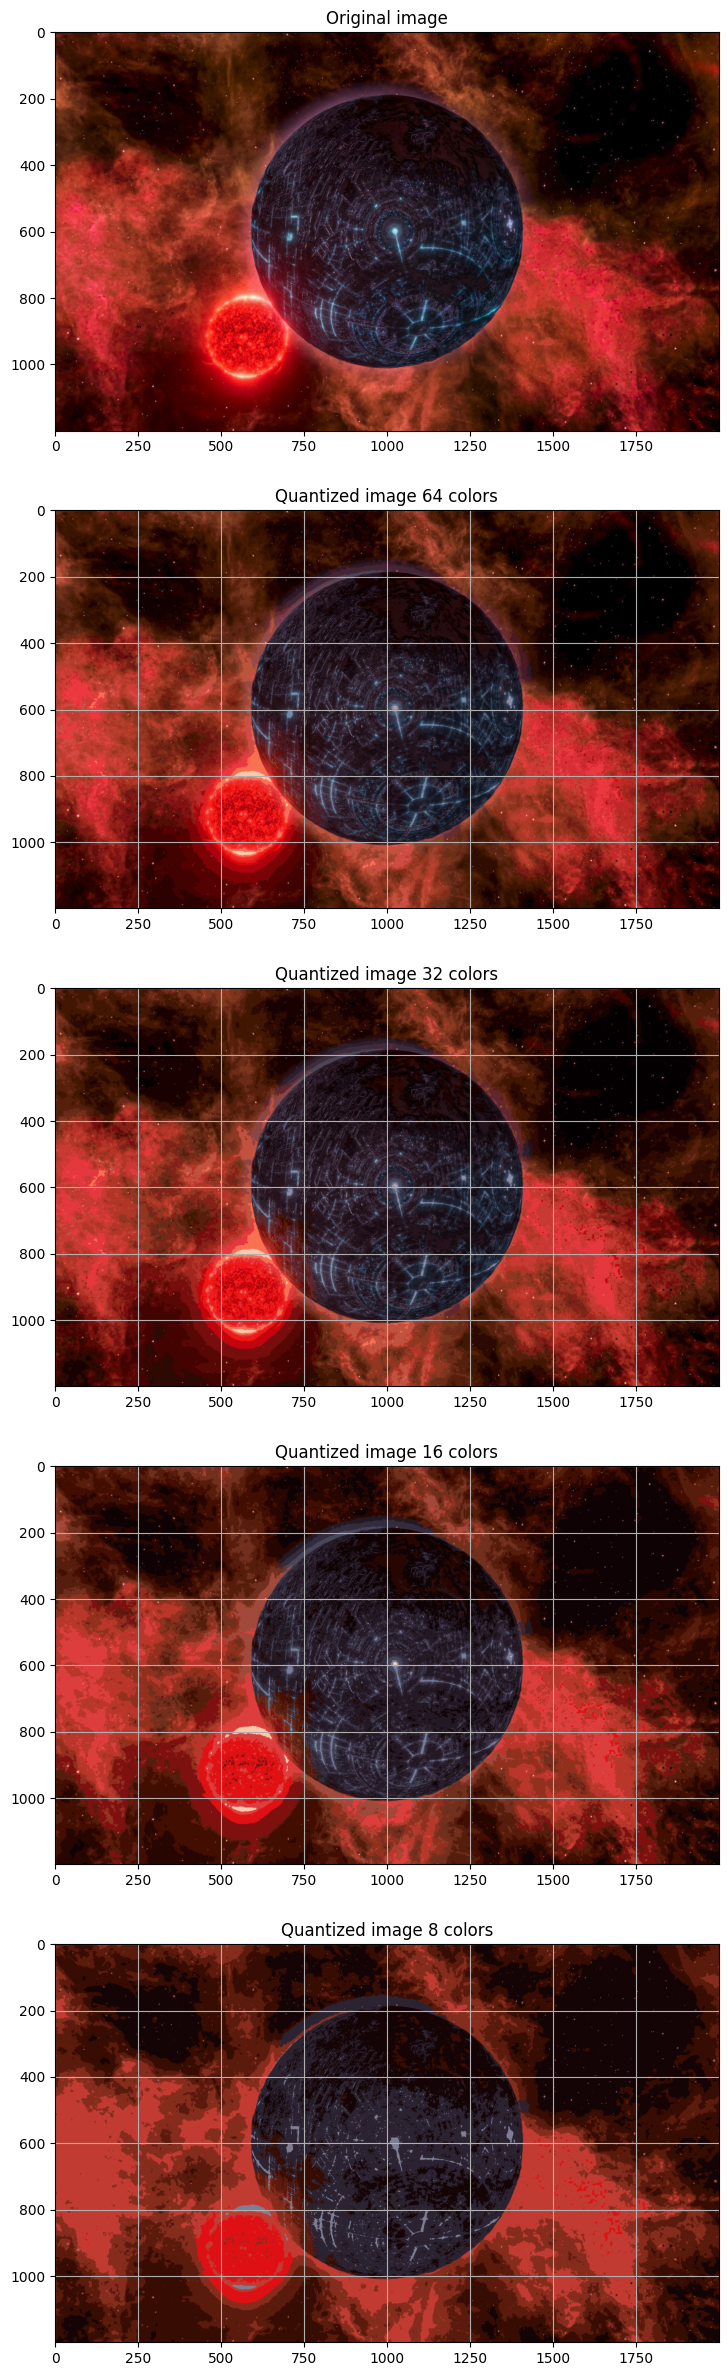

In [5]:
#2

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

img = plt.imread("alfa.jpg")/255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(img.shape)
assert d == 3
image_array = np.reshape(img, (w * h, d))

fig, axs = plt.subplots(5, 1, figsize=(45,30))

axs[0].imshow(img)
axs[0].set_title("Original image")

for ax, n_colors in zip(axs[1:], [64, 32, 16, 8]):

    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    labels = kmeans.predict(image_array)

    
    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        return codebook[labels].reshape(w, h, -1)

    
    ax.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
    ax.set_title(f"Quantized image {n_colors} colors")
    ax.grid(True)

plt.show()

In [6]:
#3

train_data = pd.read_csv(r"dataset/train.csv")
test_data = pd.read_csv(r"dataset/test.csv")

In [7]:
train_data.head()

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot o...,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry


In [8]:
train_data['Topic'].unique()

array(['Biology', 'Physics', 'Chemistry'], dtype=object)

In [9]:
train_data['emotion_encoded'] = train_data['Topic'].map({'Biology' : 0, 'Physics': 1, 'Chemistry': 2})
test_data['emotion_encoded'] = train_data['Topic'].map({'Biology' : 0, 'Physics': 1, 'Chemistry': 2})

import spacy
nlp = spacy.load("en_core_web_lg") 
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(text):
    doc = nlp(text)
    words = []
    for w in doc:
        if w.is_stop or w.is_punct:
            continue
        words.append(w.lemma_)
    return " ".join(words) 
train_data['clear_text'] = train_data['Comment'].apply(cleaning) 
test_data['clear_text'] = train_data['Comment'].apply(cleaning) 

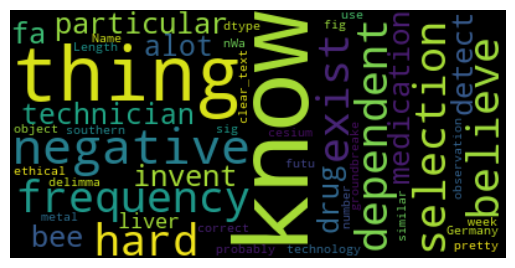

In [10]:
from wordcloud import WordCloud 

wordcloud = WordCloud().generate(str(train_data['clear_text']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train= vectorizer.fit_transform(train_data['clear_text'] )#векторизуємо дані 
X_test = vectorizer.transform(test_data['clear_text'] )

y_train = train_data['Topic']
y_test =  test_data['Topic']

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

DS_cls = DecisionTreeClassifier().fit(X_train,y_train)

y_pred = DS_cls.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Biology       0.41      0.43      0.42       614
   Chemistry       0.33      0.36      0.35       506
     Physics       0.28      0.23      0.25       466

    accuracy                           0.35      1586
   macro avg       0.34      0.34      0.34      1586
weighted avg       0.34      0.35      0.35      1586

